In [1]:
!apt-get update && apt-get install -y build-essential
!pip install xgboost
!pip install shap

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


Deploying the necessary packages required for ML

In [2]:
import pandas as pd
import xgboost as xgb

# Utility Functions

## Data Preparation
We are going to create a function that splits our data into a training set and a test set. 80% of the data will be the training set and 20% will be the test set.

In [5]:
from sklearn.model_selection import train_test_split
def prepare_data(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    ## Seperate the predictor variables (X) from the target variable (Y) and into their own dataframes

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    ## Create a training and test set for the predictor and target variables

    return X_train, X_test, y_train, y_test

## Model Evaluation
We also want to create a function to automatically evaluate the model. We will be looking at accuracy, recall, percision, f1-score, confusion matrix and the ROC Curve

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

def evaluate(model, X_test, y_test):
    pred = model.predict(X_test)
    # accuracy = correct_predictions / all_predictions 
    acc = accuracy_score(y_test, pred)

    # true_positives / (true_positives + false_postives)
    # how many positive predictions were true
    prec = precision_score(y_test, pred, average='weighted')

    # true_postives / (true_positives + false_negatives)
    # how many postives out of all were identified
    rec = recall_score(y_test, pred, average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, pred, average='weighted')
    
    print(f"accuracy: {acc}")
    print(f"precision: {prec}")
    print(f"recall: {rec}")
    print(f"f1: {f1}")
    
    try:
        prob = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, prob, multi_class='ovo')
        print(f"roc_auc: {roc_auc}")
    except:
        pass
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(model, X_test, y_test, xticks_rotation='vertical', ax=ax)
    

## Model Evaluation with Naive Rule
We want to understand what the accuracy of a Naive Rule Model is, so we create a simple function to get us the accuracy for it. This is a simple and effective way to rule out any ML model that does not make value adding predictions.

In [89]:
def naive_rule_accuracy(y_train,y_test):
    training_count = y_train.value_counts()

    unique_class = pd.unique(y_train)

    for i in unique_class:
        if training_count[i] == training_count.max():
            majority_class = i

    test_count = y_test.value_counts()
    accuracy_naive = test_count[majority_class]/test_count.sum()

    print(f"The accuracy of the Naive Model is: {accuracy_naive}")

# Binary Classification

## Data Preparation
We will load in our heart data and name the dataframe heart_data. We will also see what the data looks like by typing in our dataframe name on the line beneath the code to load in the data. This way we can get a snippet of the data to understand what it looks like. Run the cell below to load in the heart data and see what the data looks like.

In [3]:
heart_data = pd.read_csv('heart.csv')
heart_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Now we will prepare our data by splitting it into training and test sets using the function we made earlier. In order to understand exactly what this function does, we will also see what the X_Train, Y_Train, X_Test, Y_Test datasets in that order. Do you notice how they are different from the heart_data dataframe? (Hint: the target variable in also named 'target')

In [13]:
X_train, X_test, y_train, y_test = prepare_data(heart_data, 'target')
display(X_train,y_train,X_test,y_test)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
208,49,1,2,120,188,0,1,139,0,2.0,1,3,3
85,67,0,2,115,564,0,0,160,0,1.6,1,0,3
136,60,0,2,120,178,1,1,96,0,0.0,2,0,2
181,65,0,0,150,225,0,0,114,0,1.0,1,3,3
48,53,0,2,128,216,0,0,115,0,0.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,45,1,0,115,260,0,0,185,0,0.0,2,0,2
11,48,0,2,130,275,0,1,139,0,0.2,2,0,2
16,58,0,2,120,340,0,1,172,0,0.0,2,0,2
235,51,1,0,140,299,0,1,173,1,1.6,2,0,3


208    0
85     1
136    1
181    0
48     1
      ..
57     1
11     1
16     1
235    0
56     1
Name: target, Length: 242, dtype: int64

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
31,65,1,0,120,177,0,1,140,0,0.4,2,0,3
24,40,1,3,140,199,0,1,178,1,1.4,2,0,3
72,29,1,1,130,204,0,0,202,0,0.0,2,0,2
151,71,0,0,112,149,0,1,125,0,1.6,1,0,2
134,41,0,1,126,306,0,1,163,0,0.0,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,50,1,0,150,243,0,0,128,0,2.6,1,0,3
26,59,1,2,150,212,1,1,157,0,1.6,2,0,2
10,54,1,0,140,239,0,1,160,0,1.2,2,0,2
46,44,1,2,140,235,0,0,180,0,0.0,2,0,2


31     1
24     1
72     1
151    1
134    1
      ..
184    0
26     1
10     1
46     1
162    1
Name: target, Length: 61, dtype: int64

## Naive Rule Benchmark
Before we do any ML, lets look at the Naive Model accuracy. If a model cant beat the accuracy of the Naive Model, then there is no point in looking at it further.

In [91]:
naive_rule_accuracy(y_train,y_test)

The accuracy of the Naive Model is: 0.6065573770491803


## Logistic Regression Model
Now lets run a Logistic Regression Model and produce some evaluation metrics and the confusion matrix.

C:\Users\gu01042270\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy: 0.8688524590163934
precision: 0.8688524590163934
recall: 0.8688524590163934
f1: 0.8688524590163934


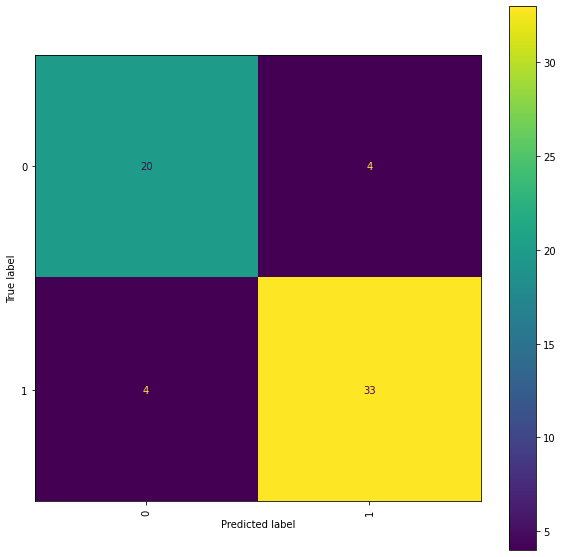

In [94]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

In [95]:
pred = model.predict(X_test)
false_positives = 0
false_negatives = 0
for prediction, truth in zip(pred, y_test):
    if truth == 1 and prediction == 0:
        false_negatives += 1
    if truth == 0 and prediction == 1:
        false_positives += 1

print(f"False Positives: {false_positives}")
print(f"False negatives: {false_negatives}")

False Positives: 4
False negatives 4


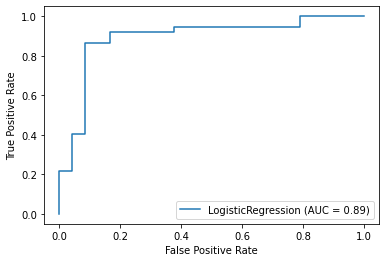

In [93]:
from sklearn.metrics import roc_curve, plot_roc_curve
roc_curve(y_test, model.predict_proba(X_test)[:,1])
plot_roc_curve(model, X_test, y_test)

# Classification (Crop Recommendation)

## Data Preparation
Now we will import the crop.csv dataset as crop_data. We will use this dataset to better predict the 'label' colunm. Run the cell below to see what the dataset looks like after it has been loaded.

In [127]:
crop_data = pd.read_csv('crops.csv')
crop_data

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


Just like the heart dataset, we will now split this dataset into training and test sets. If you would like to see what these datasets look like, run the cell, open another cell below them and type in the name(s) of the dataset(s) you wish to see (see similar example with heart_data above).

In [124]:
X_train, X_test, y_train, y_test = prepare_data(crop_data, 'label')

## Naive Rule Benchmark
Before we do any ML, lets look at the Naive Model accuracy. If a model cant beat the accuracy of the Naive Model, then there is no point in looking at it further. The Naive Rule Benchmark for this problem will be very low, given it is a multiple regression problem.

In [129]:
naive_rule_accuracy(y_train,y_test)

The accuracy of the Naive Model is: 0.031818181818181815


## Naive Bayes Model
We will first use the Naive Bayes Model on our dataset. We are using the Gaussian Naive Bayes Model as our predictor variables are continous and not discrete. Click the cell below to run it and get a confusion matrix, as well as the accuracy, percision, recall, f1 score and roc_auc.

accuracy: 0.9977272727272727
precision: 0.9978787878787879
recall: 0.9977272727272727
f1: 0.997742279730541
roc_auc: 1.0


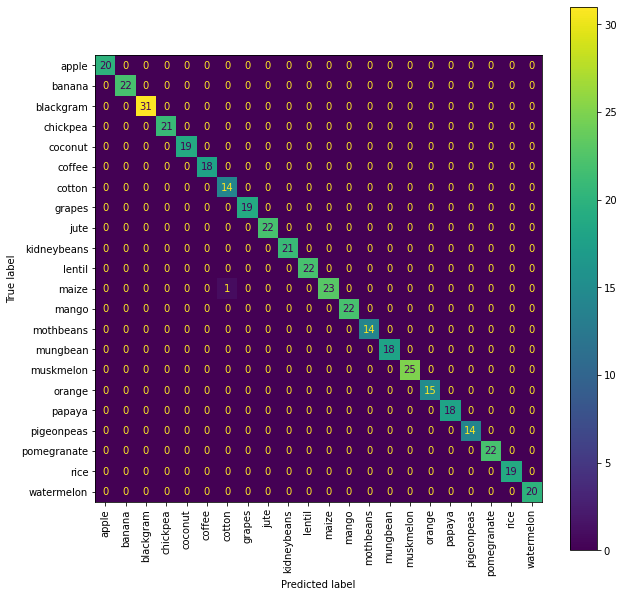

In [128]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Sochastic Gradient Descent Model
Now we will be running the Sochastic Gradient Descent Model. Click the cell below to produce the output and evaluate the model.

C:\Users\gu01042270\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.7090909090909091
precision: 0.7860241074749497
recall: 0.7090909090909091
f1: 0.6945589414223468


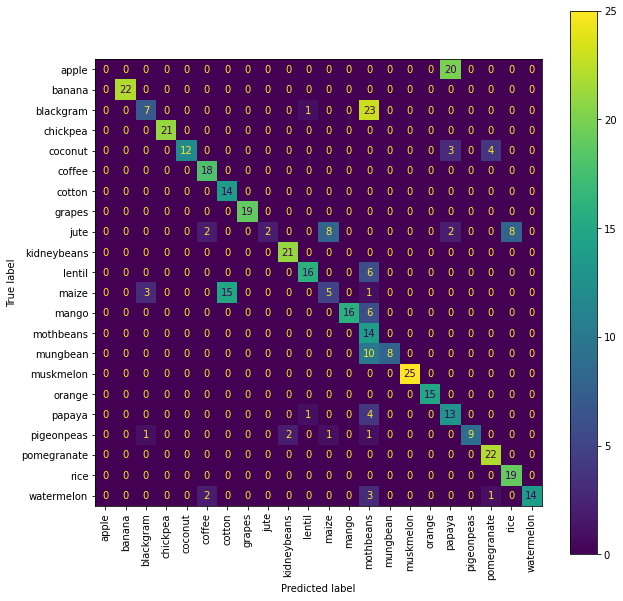

In [130]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Perceptron Model
Now we will be running the Sochastic Gradient Descent Model. Click the cell below to produce the output and evaluate the model.

C:\Users\gu01042270\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.6636363636363637
precision: 0.6510815553846041
recall: 0.6636363636363637
f1: 0.6017872697931801


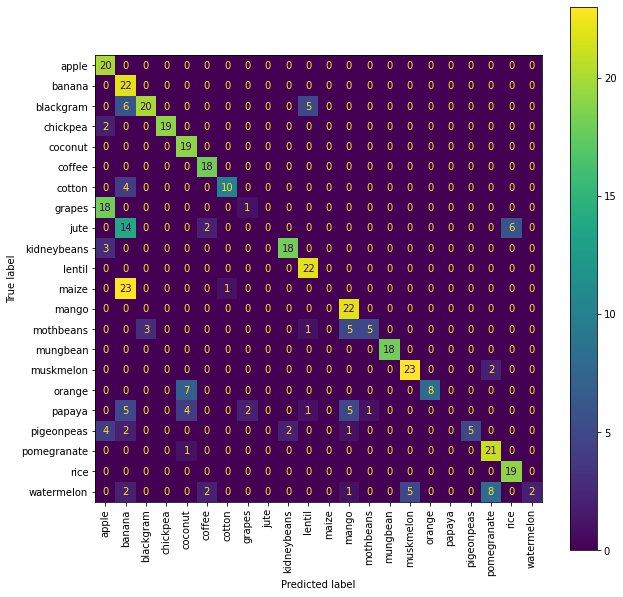

In [131]:
from sklearn.linear_model import Perceptron
model = Perceptron()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Decision Tree Model
Now we will be running a Decision Tree Model. Click the cell below to produce the output and evaluate the model.

accuracy: 0.9886363636363636
precision: 0.9893344155844156
recall: 0.9886363636363636
f1: 0.9886467344712025
roc_auc: 0.9939333814333814


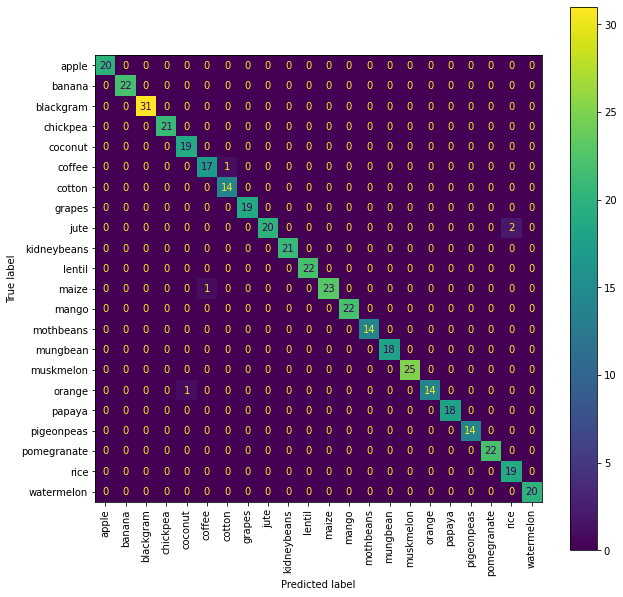

In [132]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## XGBoost Model
Now we will be running a XGBoost Model. Click the cell below to produce the output and evaluate the model.

C:\Users\gu01042270\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:44:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 0.9886363636363636
precision: 0.9892232523907686
recall: 0.9886363636363636
f1: 0.9885978214624298
roc_auc: 0.9999808836830368


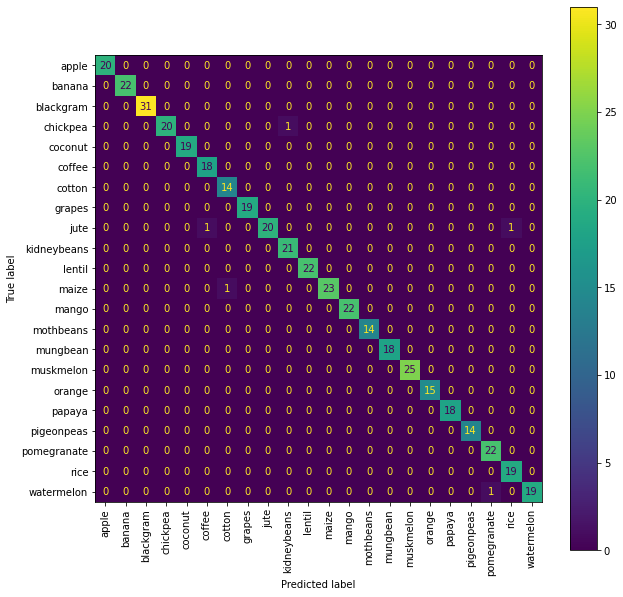

In [133]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

# Regression

## Data Preperation
Now we will load in our regression dataset and name it house_data. This dataset contains information for houses and their prices. We will train regression models with this dataset and also test them. Run the cell below to load the dataset and see what it looks like.

In [136]:
house_data = pd.read_csv('house_prices.csv')
house_data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014-07-09 00:00:00,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133,USA
4596,2014-07-09 00:00:00,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007,USA
4597,2014-07-09 00:00:00,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059,USA
4598,2014-07-10 00:00:00,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178,USA


## Categorical Encoding
Now we will use Label Encoding to convert our categorical variables (street, city and statezip) to numerical variables. This is done so the ML model can make sense of the categorical variables. Run the cell below to categorically encode these variables and see what the dataset looks like after.

In [137]:
house_data = house_data.drop(['date', 'country'], axis=1)
house_data['street'] = house_data['street'].apply(lambda x: ' '.join(x.split(' ')[1:]))
## Get rid of house number, date and country since they do not add insight to the ML Model

from sklearn.preprocessing import LabelEncoder
street_encoder = LabelEncoder()
house_data['street'] = street_encoder.fit_transform(house_data['street'])

city_encoder = LabelEncoder()
house_data['city'] = city_encoder.fit_transform(house_data['city'])

zip_encoder = LabelEncoder()
house_data['statezip'] = zip_encoder.fit_transform(house_data['statezip'])

house_data


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip
0,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,1067,36,62
1,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,2545,35,58
2,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,179,18,26
3,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,293,3,7
4,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,289,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,1288,35,62
4596,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,1988,3,6
4597,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,1184,32,37
4598,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,1947,35,71


## Split Dataset
Just like the other two datasets, we will now split this dataset into training and test sets. If you would like to see what these datasets look like, run the cell, open another cell below them and type in the name(s) of the dataset(s) you wish to see (see similar examples with heart_data above).

In [138]:
X_train, X_test, y_train, y_test = prepare_data(house_data, 'price')

## Linear Regression Model
Now we will run a linear regression model on our prepared dataset below. We will evaluate this model with 4 metrics: mean absolute error, mean squared error, root mean squared error and the R2 score. Run the cell below to get these 4 metrics.

In [139]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2: {r2}")

Mean Absolute Error: 185864.340271862
Mean Squared Error: 248498694179.83493
Root Mean Squared Error: 498496.4334675173
R2: 0.2493193051188144


# Hyperparameter Tuning

In [167]:
X_train, X_test, y_train, y_test = prepare_data(crop_data, 'label')

In [168]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "penalty": ['l1', 'l2', 'elasticnet'], ## The various options to put a penalty on errors (also known as regularization)
    "alpha": [0.0001, 0.001, 0.01], ## The constant that multiplies the regularization term. The higher the value the, the stronger the regularization
    "eta0": [0.001, 0.01, 0.1], ## The initial learning rate for the model. Will change with adaptive learning
    "learning_rate": ['constant', 'adaptive'] ## Does the model keep the learning rate constant or change as it runs based on performance
}
grid_cv = GridSearchCV(SGDClassifier(), param_grid, n_jobs=-1, cv=5, scoring="f1_weighted")

In [169]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'eta0': [0.001, 0.01, 0.1],
                         'learning_rate': ['constant', 'adaptive'],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='f1_weighted')

In [170]:
grid_cv.best_score_

0.8524432449673579

In [171]:
grid_cv.best_params_

{'alpha': 0.01,
 'eta0': 0.1,
 'learning_rate': 'adaptive',
 'penalty': 'elasticnet'}

In [172]:
model = grid_cv.best_estimator_

accuracy: 0.884090909090909
precision: 0.9197267316017316
recall: 0.884090909090909
f1: 0.891655239389829


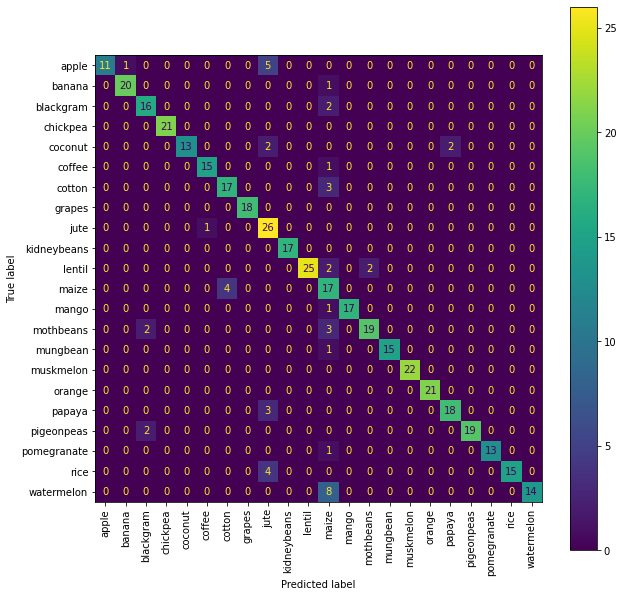

In [173]:
evaluate(model, X_test, y_test)

# Feature Scaling
We want to see if our model preforms any better if we standardize or normalize the data. Just like before we will be using our crop data and splitting into training and test sets. We will be using the same SGDC classifier because that model had some room for improvement. We want to see if either standardization or normalization will improve the model.

## Data Prep
First step is to split the data into training and test sets

In [148]:
X_train, X_test, y_train, y_test = prepare_data(crop_data, 'label')

Now we will scale the data. We are going to both normalize the data and standardize it.

In [149]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = crop_data.drop("label", axis=1)
y = crop_data["label"]

standard_scaler = StandardScaler()
standard_scaler.fit(X)
X_s_scaled = pd.DataFrame(standard_scaler.transform(X), columns=X.columns)

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X)
X_mm_scaled = pd.DataFrame(minmax_scaler.transform(X), columns=X.columns)
with pd.option_context('display.float_format', lambda x: '%.3f' % x):  
    print("Unscaled Data:") 
    display(X.describe())
    print("Standardized Data:")
    display(X_s_scaled.describe())
    print("Normalized Data:")
    display(X_mm_scaled.describe())

Unscaled Data:


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000,2200.000,2200.000,2200.000,2200.000,2200.000,2200.000
mean,50.552,53.363,48.149,25.616,71.482,6.469,103.464
std,36.917,32.986,50.648,5.064,22.264,0.774,54.958
min,0.000,5.000,5.000,8.826,14.258,3.505,20.211
25%,21.000,28.000,20.000,22.769,60.262,5.972,64.552
50%,37.000,51.000,32.000,25.599,80.473,6.425,94.868
75%,84.250,68.000,49.000,28.562,89.949,6.924,124.268
max,140.000,145.000,205.000,43.675,99.982,9.935,298.560


Standardized Data:


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000,2200.000,2200.000,2200.000,2200.000,2200.000,2200.000
mean,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.370,-1.466,-0.852,-3.317,-2.571,-3.832,-1.515
25%,-0.801,-0.769,-0.556,-0.562,-0.504,-0.643,-0.708
50%,-0.367,-0.072,-0.319,-0.003,0.404,-0.057,-0.156
75%,0.913,0.444,0.017,0.582,0.830,0.587,0.379
max,2.423,2.779,3.098,3.567,1.280,4.479,3.551


Normalized Data:


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000,2200.000,2200.000,2200.000,2200.000,2200.000,2200.000
mean,0.361,0.345,0.216,0.482,0.668,0.461,0.299
std,0.264,0.236,0.253,0.145,0.260,0.120,0.197
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.150,0.164,0.075,0.400,0.537,0.384,0.159
50%,0.264,0.329,0.135,0.481,0.772,0.454,0.268
75%,0.602,0.450,0.220,0.566,0.883,0.532,0.374
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000


## Unscaled Data
We are going to run the same model on the three datasets above and see which one comes out with the best performance. All of them are SGDC Models and we will see the confusion matrix, accuracy, percision, recall and the f1 score.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


accuracy: 0.6681818181818182
precision: 0.759317618054987
recall: 0.6681818181818182
f1: 0.6320784666152437


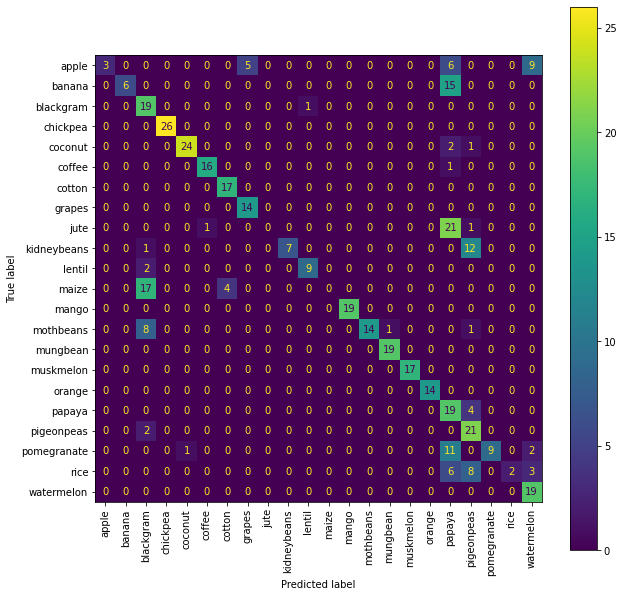

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = SGDClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Standardized Data

accuracy: 0.8909090909090909
precision: 0.9381344101019559
recall: 0.8909090909090909
f1: 0.9028119728069685


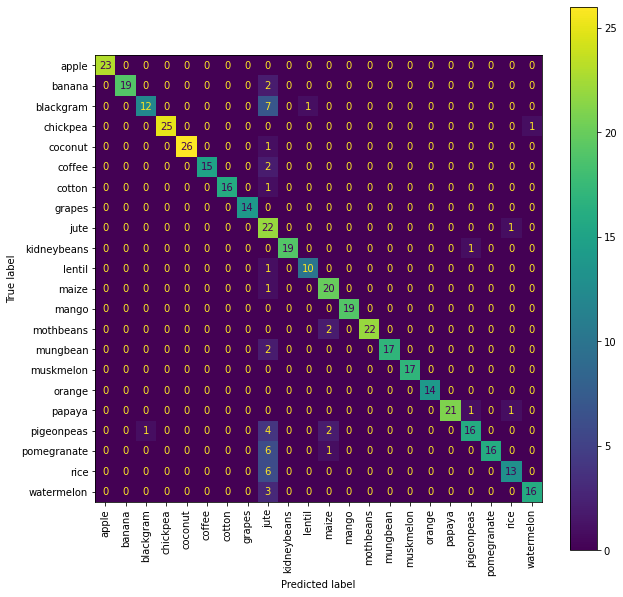

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X_s_scaled, y, test_size=0.2, random_state=42)
model = SGDClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Normalized Data

accuracy: 0.8568181818181818
precision: 0.8805676215619398
recall: 0.8568181818181818
f1: 0.8484967545154686


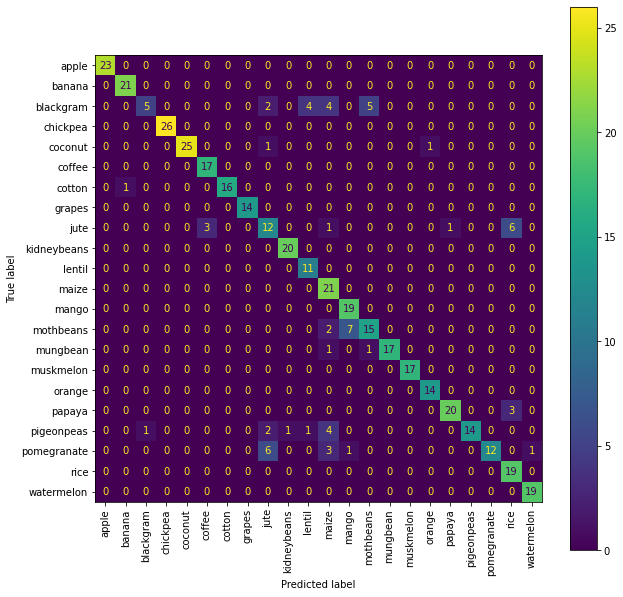

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X_mm_scaled, y, test_size=0.2, random_state=42)
model = SGDClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

# SHAP Values

In [142]:
import shap

In [143]:
X_train, X_test, y_train, y_test = prepare_data(crop_data, 'label')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:58:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 0.9954545454545455
precision: 0.9957048748353096
recall: 0.9954545454545455
f1: 0.9954648396852125
roc_auc: 1.0


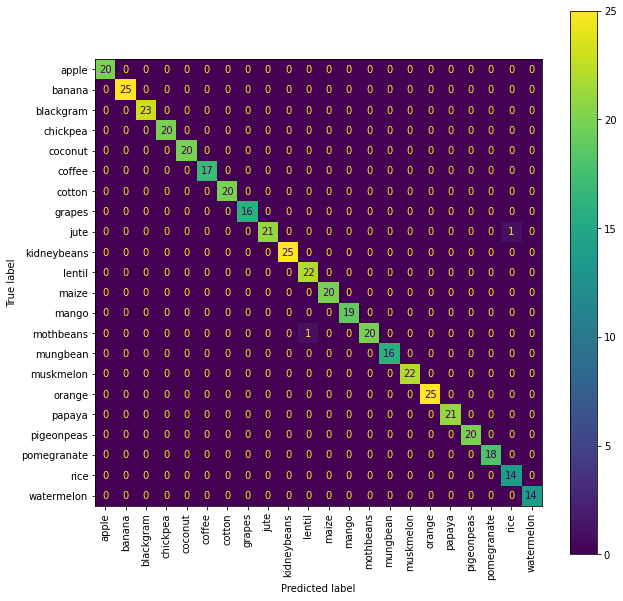

In [144]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

In [154]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

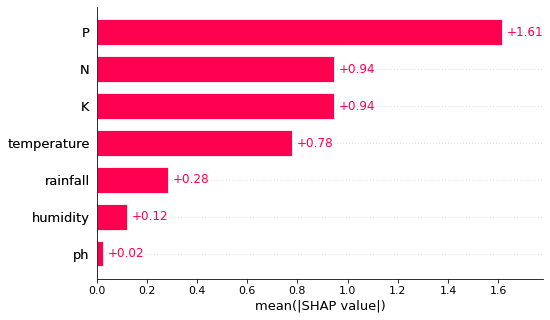

In [166]:
shap.plots.bar(shap_values[...,21])